In [1]:
from goes2go import GOES
import pandas as pd
from datetime import datetime
import xarray as xr
import subprocess
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

# Data Cleaning and Preprocessing for GOES Cloud and Moisture Data

This notebook covers the data cleaning and preprocessing steps necessary to prepare GOES satellite data for further analysis. The notebook focuses on handling cloud and moisture, cloud optical depth, and reflected shortwave radiation data, with the goal of transforming projection coordinates into usable latitude and longitude data.

## 1. Loading Data

First, we load three key datasets stored in numpy arrays, each representing different aspects of cloud and moisture data collected by GOES satellites.


In [2]:
file_array_cloud_and_moisture = np.load('file_list_cloud_and_moisture.npy')
file_array_cloud_optical_depth = np.load('file_list_cloud_optical_depth.npy')
file_array_reflected_sw = np.load('file_list_reflected_sw.npy')

## 2. Coordinate Transformation
GOES satellite data is provided in a specific projection with coordinates in radians. To make this data useful for geographic analysis, we need to transform these projection coordinates (x and y) into latitude and longitude values. This is accomplished with the calculate_degrees function.

calculate_degrees function

this function comes directly from scientists at NESDIS, the link to find the script and other usefulinformation about the function can be found here:

https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_abi_lat_lon.php

Acknowledgment:

the NOAA/NESDIS/STAR Aerosols and Atmospheric Composition Science Team

The calculate_degrees function handles the transformation of projection coordinates into latitude and longitude:

In [3]:
def calculate_degrees(file_id):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return abi_lat, abi_lon

# Cloud Imagery Processing Function

The `CloudImageryProcessingFunction` loads and processes GOES satellite data to produce a corrected true-color RGB image. This function also calculates and returns latitude and longitude values based on the GOES fixed grid projection.

## Function Inputs
- **file**: Path to the NetCDF file containing GOES data.

## Function Workflow

1. **Open the Dataset**:
   - `ds = xr.open_dataset(file)` loads the file into an `xarray` dataset.
   - `file_id = Dataset(file)` opens the file for use with the `calculate_degrees` function.

2. **Latitude and Longitude Calculation**:
   - `abi_lat, abi_lon = calculate_degrees(file_id)` uses `calculate_degrees` to convert projection coordinates into usable latitude and longitude arrays. These will match the spatial dimensions of the RGB channels.

3. **Extract RGB Channels**:
   - Channels **C02** (red), **C03** (green), and **C01** (blue) are loaded from the dataset as `R`, `G`, and `B`.
   
4. **Clip and Gamma Correct RGB Values**:
   - Each channel is clipped between 0 and 1 to limit RGB values.
   - A gamma correction is applied with a factor of 2.2 to adjust image brightness for a more natural appearance.

5. **Calculate True Green**:
   - **True Green** is calculated using a weighted blend of the three channels: `G_true = 0.45 * R + 0.1 * G + 0.45 * B`.
   - This formula ensures that the green channel closely matches natural color hues.

6. **Create RGB Array**:
   - The RGB channels are combined into a single 3D array using `np.dstack`.
   - `rgb = RGB[:,:-1,:]` removes any extraneous pixels or artifacts from the array if necessary.

7. **Return Values**:
   - Returns the calculated latitude (`abi_lat`), longitude (`abi_lon`), and the final RGB image array (`rgb`).

## Example Output
- **abi_lat, abi_lon**: Arrays containing the latitude and longitude values.
- **rgb**: The RGB image array, with each channel adjusted and combined for true-color representation.


In [4]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset

def CloudImageryProcessingFunction(file):
    print(file)
    ds = xr.open_dataset(file)
    file_id = Dataset(file)

    # Call function to calculate latitude and longitude from GOES ABI fixed grid projection data
    abi_lat, abi_lon = calculate_degrees(file_id)

    # Load the three channels into appropriate R, G, and B variables
    R = ds['CMI_C02'].data
    G = ds['CMI_C03'].data
    B = ds['CMI_C01'].data

    # Define a function to remove outliers based on IQR
    def remove_outliers(data):
        Q1, Q3 = np.percentile(data, [25, 75])
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = np.clip(data, lower_bound, upper_bound)
        return data

    # Remove outliers from each channel
    R = remove_outliers(R)
    G = remove_outliers(G)
    B = remove_outliers(B)

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    # Apply a gamma correction to the image
    gamma = 2.2
    R = np.power(R, 1/gamma)
    G = np.power(G, 1/gamma)
    B = np.power(B, 1/gamma)

    # Calculate the "True" Green
    G_true = 0.45 * R + 0.1 * G + 0.45 * B
    G_true = np.maximum(G_true, 0)
    G_true = np.minimum(G_true, 1)

    # The RGB array for the true color image
    RGB = np.dstack([R, G_true, B])
    rgb = RGB[:,:-1,:] # reverse the green???

    return abi_lat, abi_lon, rgb


# Cloud Optical Depth Processing Function

The `CloudOpticalDepthProcessingFunction` processes GOES satellite data to extract cloud optical depth (COD) information along with latitude and longitude coordinates. This function is essential for geolocating and analyzing cloud properties in GOES data.

## Function Inputs
- **file**: Path to the NetCDF file containing GOES cloud optical depth data.

## Function Workflow

1. **Open the Dataset**:
   - `ds = xr.open_dataset(file)` loads the file into an `xarray` dataset.
   - `file_id = Dataset(file)` opens the file to use with the `calculate_degrees` function.

2. **Latitude and Longitude Calculation**:
   - `abi_lat, abi_lon = calculate_degrees(file_id)` calls the `calculate_degrees` function to convert the GOES fixed grid projection into latitude and longitude arrays, matching the spatial dimensions of the COD data.

3. **Extract Cloud Optical Depth (COD)**:
   - `cod = ds['COD'].data` extracts the cloud optical depth data from the dataset. COD is a measure of cloud thickness and light attenuation, useful for analyzing cloud properties and dynamics.

4. **Return Values**:
   - Returns the calculated latitude (`abi_lat`), longitude (`abi_lon`), and COD data.

## Example Output
- **abi_lat, abi_lon**: Arrays containing latitude and longitude values.
- **cod**: Array containing the cloud optical depth data.

## Application
This function provides georeferenced COD data, which is critical for studying cloud composition and the effects of clouds on atmospheric radiation.


In [5]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset

# Data processing
def CloudOpticalDepthProcessingFunction(file):
    print(file)
    ds = xr.open_dataset(file)
    file_id = Dataset(file)

    # Call function to calculate latitude and longitude from GOES ABI fixed grid projection data
    abi_lat, abi_lon = calculate_degrees(file_id)

    # Load Cloud Optical Depth (COD) data
    cod = ds['COD'].data

    # Define a function to remove outliers based on IQR
    def remove_outliers(data):
        Q1, Q3 = np.percentile(data, [25, 75])
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = np.clip(data, lower_bound, upper_bound)
        return data

    # Remove outliers from the COD data
    cod = remove_outliers(cod)

    return abi_lat, abi_lon, cod


# Reflected Shortwave Radiation Processing Function

The `ReflectedSWProcessingFunction` processes GOES satellite data to extract reflected shortwave radiation (RSR) information, along with latitude and longitude coordinates. This function is used to analyze the amount of solar radiation reflected by the Earth's surface and atmosphere, which is crucial for understanding energy balance.

## Function Inputs
- **file**: Path to the NetCDF file containing GOES reflected shortwave radiation data.

## Function Workflow

1. **Open the Dataset**:
   - `ds = xr.open_dataset(file)` loads the file into an `xarray` dataset.
   - `file_id = Dataset(file)` opens the file for further processing if needed.

2. **Extract Latitude and Longitude**:
   - `abi_lat = ds['lat'].values` and `abi_lon = ds['lon'].values` retrieve the latitude and longitude values directly from the dataset, which represent the spatial grid of the RSR data.

3. **Extract Reflected Shortwave Radiation (RSR)**:
   - `rsr = ds['RSR'].data` extracts the reflected shortwave radiation data from the dataset. This parameter measures the intensity of sunlight reflected by clouds, surface, and atmosphere.

4. **Return Values**:
   - Returns the latitude (`abi_lat`), longitude (`abi_lon`), and RSR data.

## Example Output
- **abi_lat, abi_lon**: Arrays containing the latitude and longitude values.
- **rsr**: Array containing the reflected shortwave radiation data.

## Application
This function provides georeferenced RSR data, essential for studies on surface albedo, cloud reflectivity, and radiative forcing, which are key factors in climate modeling and weather forecasting.


In [6]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset

def ReflectedSWProcessingFunction(file):
    print(file)
    ds = xr.open_dataset(file)
    file_id = Dataset(file)

    # Extract latitude and longitude
    abi_lat = ds['lat'].values
    abi_lon = ds['lon'].values

    # Load Reflected Shortwave Radiation (RSR) data
    rsr = ds['RSR'].data

    # Define a function to remove outliers based on IQR
    def remove_outliers(data):
        Q1, Q3 = np.percentile(data, [25, 75])
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = np.clip(data, lower_bound, upper_bound)
        return data

    # Remove outliers from the RSR data
    rsr = remove_outliers(rsr)

    return abi_lat, abi_lon, rsr


In [7]:
# Process data for Julian day 91
cloudimagery91_lat, cloudimagery91_lon, cloudimagery91_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[0])
reflectedsw91_lat, reflectedsw91_lon, reflectedsw91_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[0])
cloudopticaldepth91_lat, cloudopticaldepth91_lon, cloudopticaldepth91_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[0])

# Process data for Julian day 92
cloudimagery92_lat, cloudimagery92_lon, cloudimagery92_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[1])
reflectedsw92_lat, reflectedsw92_lon, reflectedsw92_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[1])
cloudopticaldepth92_lat, cloudopticaldepth92_lon, cloudopticaldepth92_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[1])

# Process data for Julian day 93
cloudimagery93_lat, cloudimagery93_lon, cloudimagery93_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[2])
reflectedsw93_lat, reflectedsw93_lon, reflectedsw93_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[2])
cloudopticaldepth93_lat, cloudopticaldepth93_lon, cloudopticaldepth93_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[2])

# Process data for Julian day 94
cloudimagery94_lat, cloudimagery94_lon, cloudimagery94_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[3])
reflectedsw94_lat, reflectedsw94_lon, reflectedsw94_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[3])
cloudopticaldepth94_lat, cloudopticaldepth94_lon, cloudopticaldepth94_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[3])

# Process data for Julian day 95
cloudimagery95_lat, cloudimagery95_lon, cloudimagery95_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[4])
reflectedsw95_lat, reflectedsw95_lon, reflectedsw95_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[4])
cloudopticaldepth95_lat, cloudopticaldepth95_lon, cloudopticaldepth95_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[4])

# Process data for Julian day 96
cloudimagery96_lat, cloudimagery96_lon, cloudimagery96_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[5])
reflectedsw96_lat, reflectedsw96_lon, reflectedsw96_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[5])
cloudopticaldepth96_lat, cloudopticaldepth96_lon, cloudopticaldepth96_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[5])

# Process data for Julian day 97
cloudimagery97_lat, cloudimagery97_lon, cloudimagery97_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[6])
reflectedsw97_lat, reflectedsw97_lon, reflectedsw97_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[6])
cloudopticaldepth97_lat, cloudopticaldepth97_lon, cloudopticaldepth97_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[6])

# Process data for Julian day 98
cloudimagery98_lat, cloudimagery98_lon, cloudimagery98_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[7])
reflectedsw98_lat, reflectedsw98_lon, reflectedsw98_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[7])
cloudopticaldepth98_lat, cloudopticaldepth98_lon, cloudopticaldepth98_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[7])

# Process data for Julian day 99
cloudimagery99_lat, cloudimagery99_lon, cloudimagery99_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[8])
reflectedsw99_lat, reflectedsw99_lon, reflectedsw99_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[8])
cloudopticaldepth99_lat, cloudopticaldepth99_lon, cloudopticaldepth99_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[8])

# Process data for Julian day 100
cloudimagery100_lat, cloudimagery100_lon, cloudimagery100_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[9])
reflectedsw100_lat, reflectedsw100_lon, reflectedsw100_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[9])
cloudopticaldepth100_lat, cloudopticaldepth100_lon, cloudopticaldepth100_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[9])


C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2020day91.nc


C:\Users\adhal\AppData\Local\Temp\ipykernel_29456\3872720453.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2020day91.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2020day91.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2020day92.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2020day92.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2020day92.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2020day93.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2020day93.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2020day93.nc
C:/Use

In [8]:
# Create a dictionary to store all the processed data for Julian days 91 to 100
data_dict = {
    'Julian_day_91': {
        'cloud_imagery': {'lat': cloudimagery91_lat, 'lon': cloudimagery91_lon, 'rgb': cloudimagery91_rgb},
        'reflected_sw': {'lat': reflectedsw91_lat, 'lon': reflectedsw91_lon, 'rsr': reflectedsw91_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth91_lat, 'lon': cloudopticaldepth91_lon, 'cod': cloudopticaldepth91_cod}
    },
    'Julian_day_92': {
        'cloud_imagery': {'lat': cloudimagery92_lat, 'lon': cloudimagery92_lon, 'rgb': cloudimagery92_rgb},
        'reflected_sw': {'lat': reflectedsw92_lat, 'lon': reflectedsw92_lon, 'rsr': reflectedsw92_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth92_lat, 'lon': cloudopticaldepth92_lon, 'cod': cloudopticaldepth92_cod}
    },
    'Julian_day_93': {
        'cloud_imagery': {'lat': cloudimagery93_lat, 'lon': cloudimagery93_lon, 'rgb': cloudimagery93_rgb},
        'reflected_sw': {'lat': reflectedsw93_lat, 'lon': reflectedsw93_lon, 'rsr': reflectedsw93_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth93_lat, 'lon': cloudopticaldepth93_lon, 'cod': cloudopticaldepth93_cod}
    },
    'Julian_day_94': {
        'cloud_imagery': {'lat': cloudimagery94_lat, 'lon': cloudimagery94_lon, 'rgb': cloudimagery94_rgb},
        'reflected_sw': {'lat': reflectedsw94_lat, 'lon': reflectedsw94_lon, 'rsr': reflectedsw94_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth94_lat, 'lon': cloudopticaldepth94_lon, 'cod': cloudopticaldepth94_cod}
    },
    'Julian_day_95': {
        'cloud_imagery': {'lat': cloudimagery95_lat, 'lon': cloudimagery95_lon, 'rgb': cloudimagery95_rgb},
        'reflected_sw': {'lat': reflectedsw95_lat, 'lon': reflectedsw95_lon, 'rsr': reflectedsw95_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth95_lat, 'lon': cloudopticaldepth95_lon, 'cod': cloudopticaldepth95_cod}
    },
    'Julian_day_96': {
        'cloud_imagery': {'lat': cloudimagery96_lat, 'lon': cloudimagery96_lon, 'rgb': cloudimagery96_rgb},
        'reflected_sw': {'lat': reflectedsw96_lat, 'lon': reflectedsw96_lon, 'rsr': reflectedsw96_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth96_lat, 'lon': cloudopticaldepth96_lon, 'cod': cloudopticaldepth96_cod}
    },
    'Julian_day_97': {
        'cloud_imagery': {'lat': cloudimagery97_lat, 'lon': cloudimagery97_lon, 'rgb': cloudimagery97_rgb},
        'reflected_sw': {'lat': reflectedsw97_lat, 'lon': reflectedsw97_lon, 'rsr': reflectedsw97_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth97_lat, 'lon': cloudopticaldepth97_lon, 'cod': cloudopticaldepth97_cod}
    },
    'Julian_day_98': {
        'cloud_imagery': {'lat': cloudimagery98_lat, 'lon': cloudimagery98_lon, 'rgb': cloudimagery98_rgb},
        'reflected_sw': {'lat': reflectedsw98_lat, 'lon': reflectedsw98_lon, 'rsr': reflectedsw98_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth98_lat, 'lon': cloudopticaldepth98_lon, 'cod': cloudopticaldepth98_cod}
    },
    'Julian_day_99': {
        'cloud_imagery': {'lat': cloudimagery99_lat, 'lon': cloudimagery99_lon, 'rgb': cloudimagery99_rgb},
        'reflected_sw': {'lat': reflectedsw99_lat, 'lon': reflectedsw99_lon, 'rsr': reflectedsw99_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth99_lat, 'lon': cloudopticaldepth99_lon, 'cod': cloudopticaldepth99_cod}
    },
    'Julian_day_100': {
        'cloud_imagery': {'lat': cloudimagery100_lat, 'lon': cloudimagery100_lon, 'rgb': cloudimagery100_rgb},
        'reflected_sw': {'lat': reflectedsw100_lat, 'lon': reflectedsw100_lon, 'rsr': reflectedsw100_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth100_lat, 'lon': cloudopticaldepth100_lon, 'cod': cloudopticaldepth100_cod}
    }
}


In [9]:
import pickle
# Save the dictionary to a file using pickle
file_path = 'C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/cleaned_data.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(data_dict, f)

# Confirm file saved
print(f"Data dictionary saved to {file_path}")

Data dictionary saved to C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/cleaned_data.pkl


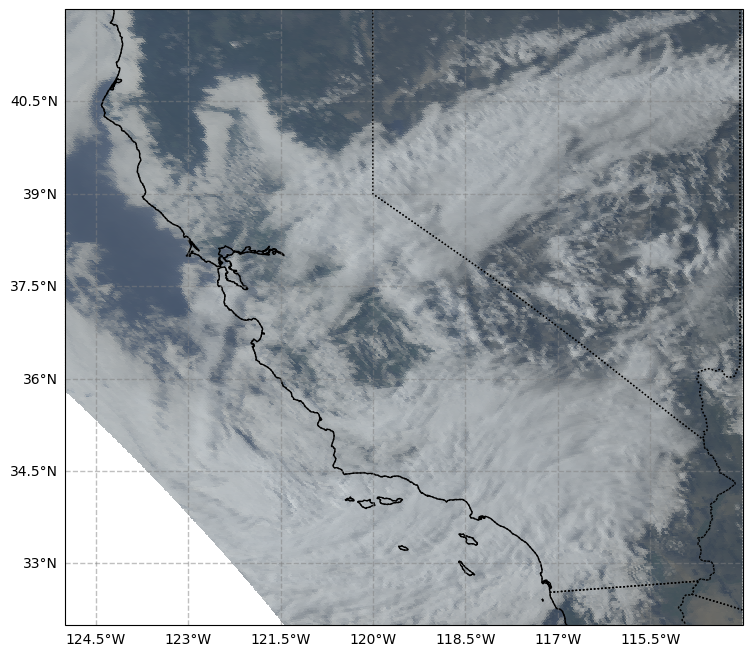

In [10]:
# Create the plot using cartopy
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent to focus on California region
ax.set_extent([-125, -114, 32, 42], crs=ccrs.PlateCarree())

# Plot the GOES data using pcolormesh with the calculated lat/lon
ax.pcolormesh(cloudimagery100_lon, cloudimagery100_lat, cloudimagery100_rgb, transform=ccrs.PlateCarree(), cmap='Greys', shading='auto')

# Add coastlines and map features for context
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add latitude/longitude gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Don't show labels on the top
gl.right_labels = False  # Don't show labels on the right
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Show the plot
plt.show()

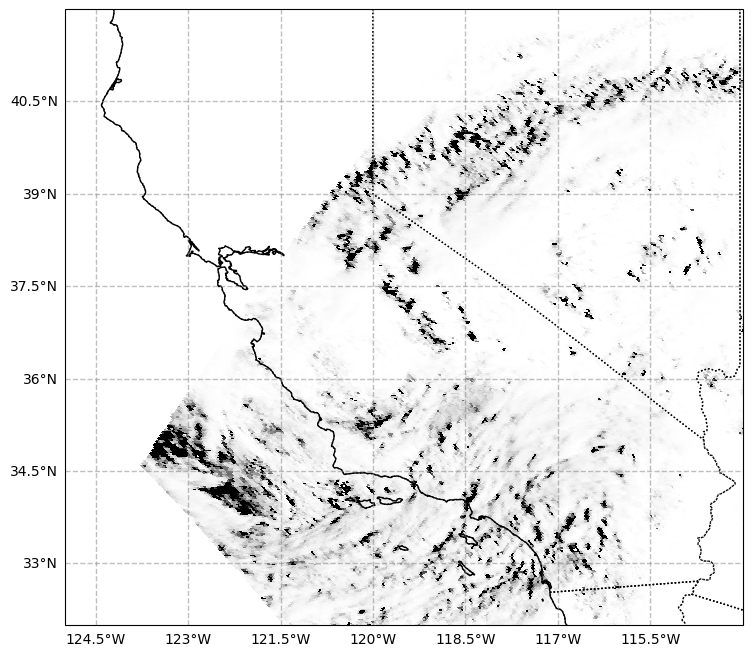

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent to focus on California region
ax.set_extent([-125, -114, 32, 42], crs=ccrs.PlateCarree())

# Plot the GOES data using pcolormesh with the calculated lat/lon
ax.pcolormesh(cloudopticaldepth100_lon, cloudopticaldepth100_lat, cloudopticaldepth100_cod, transform=ccrs.PlateCarree(), cmap='Greys', shading='auto')

# Add coastlines and map features for context
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add latitude/longitude gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Don't show labels on the top
gl.right_labels = False  # Don't show labels on the right
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Show the plot
plt.show()
